# Compare model rh and calculated rh

In [1]:

import sys
print(sys.executable)
sys.path


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python


['/home/m/m301053/RH_Analysis_V2/Eval_sh',
 '/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python310.zip',
 '/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10',
 '/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/lib-dynload',
 '',
 '/home/m/m301053/.local/lib/python3.10/site-packages',
 '/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages',
 '/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/GDAL-3.5.0-py3.10-linux-x86_64.egg']

In [2]:
# load stuff:
import datetime as dt

from dataload_helper import Dataset
from dataeval_helper import *  # load here also numpy, scipy,...
from global_params import *
from physics_helper import init_rh_calc_vals



ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj failed


In [3]:
#load Datasets

SETNAME="MERRA2"
#SETNAME="JRA-55"

#Global Params
if SETNAME=="MERRA":
    FILES="../Data/Merra_inst3_3d_asm_Cp_1979-2016/instM_3d_asm_Cp_197901_201601.nc"
    RESLOC = '../Results/'
    RESLOC_SPECIFIC = 'MERRA_RH/'
    DATALOC_SPECIFIC = 'Merra_inst3_3d_asm_Cp_1979-2016/'
    DATALOC = '../Data/' + DATALOC_SPECIFIC
elif SETNAME=="MERRA2":
    FILES="../../../../../../work/mh0066/m301053/Data/MERRA2_instM_3d_asm_Np_all/MERRA2_*"
    DATALOC_SPECIFIC = 'MERRA2_instM_3d_asm_Np_all/'
    DATALOC = '../../../../../../work/mh0066/m301053/Data/' + DATALOC_SPECIFIC
elif SETNAME=="JRA-55":
    FILES="../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_isobaric_sh/*.nc"
   
    DATALOC_SPECIFIC = 'JRA-55_Monthly_1.25_Deg_isobaric_sh/'
    DATALOC = '../../../../../../work/mh0066/m301053/Data/' + DATALOC_SPECIFIC
else:
    raise Exception("Sorry, notexisting Setname")
    
RESLOC = '../Res_sh/'#'../Results/'#'../NicePlots/'
RESLOC_SPECIFIC = SETNAME
#What parts of the Notebook should run?
TOPOANALYSIS=False

MASKELEVATION=True
SURFACEVALUES=True

TvsRHANALYSIS=True



#Times for analysis
if SETNAME=="JRA-55":
    t1_start='1958-01-01'
    t1_end='1973-12-01'
    t2_start='2007-01-01'
    t2_end='2021-12-01'

if SETNAME=="MERRA2":
    t1_start='1980-01-01'
    t1_end='1989-12-01'
    t2_start='2010-01-01'
    t2_end='2022-12-01'

In [4]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    DS = Dataset(files=FILES, setname = SETNAME, dataloc = DATALOC)

Loading full dataset MERRA2
<xarray.Dataset>
Dimensions:   (time: 522, p: 42, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * p         (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01
Data variables:
    RH_model  (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    T         (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    SH        (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original file generated: Thu May  7 22...
    Filename:                          MERRA2_100.instM_3d_asm_Np.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.inst3_3d...
    Conven

In [5]:
if MASKELEVATION==True and SETNAME=="JRA-55":
    DS_2D = Dataset(files='../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_surface_1958-2021/anl*pres*.nc', setname = 'JRA-55_2D', dataloc = '../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_surface/')
    DS.ds = elevation2nan( DS.ds, DS_2D.ds )
    print(DS.ds)

In [6]:
# =======================================================================
#Initilize topography analysis
if TOPOANALYSIS==True:
    TOPO = Dataset(files="../../../../../../work/mh0066/m301053/Data/Topo/topo_r720x360.nc", setname = 'TOPO', dataloc = '../../../../../../work/mh0066/m301053/Data/Topo/')
    TOPO.land_mask = xr.where(TOPO.ds.topo >= 0.0, True, False)
    
    # Reindex the land mask to match the climate data grid
    TOPO.land_mask_reindexed = TOPO.land_mask.reindex_like(DS.ds, method='nearest')
    #print(TOPO.land_mask_reindexed)
    #TOPO.ds.where(TOPO.land_mask_reindexed==False).topo.plot(ax=ax, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_elevation,cbar_kwargs= cbar_kwargs) for ocean


In [7]:
#DS.ds=DS.ds.sel(time=slice('2021-01-01',t2_end))
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    init_rh_calc_vals(DS)

Load existing file for rh_calc_vals from ../../../../../../work/mh0066/m301053/Data/MERRA2_instM_3d_asm_Np_all/rh_calc_vals.netcdf
<xarray.Dataset>
Dimensions:   (lat: 361, p: 42, lon: 576, time: 522)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * p         (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01
Data variables:
    RH_model  (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    T         (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    SH        (time, p, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    RH_calc   (time, p, lat, lon) float64 dask.array<chunksize=(2, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original

In [8]:
DS.ds.RH_calc
#print(DS.ds.RH_calc.to_numpy())

<xarray.DataArray 'RH_calc' (time: 522, p: 42, lat: 361, lon: 576)>
dask.array<where, shape=(522, 42, 361, 576), dtype=float64, chunksize=(2, 42, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01
Attributes:
    description:  RH calculated from SH.

In [9]:
DS.ds.RH_model

<xarray.DataArray 'RH_model' (time: 522, p: 42, lat: 361, lon: 576)>
dask.array<concatenate, shape=(522, 42, 361, 576), dtype=float32, chunksize=(1, 42, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01
Attributes:
    long_name:       relative_humidity_after_moist
    units:           1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    origname:        RH
    fullnamepath:    /RH

[########################################] | 100% Completed | 146.56 s


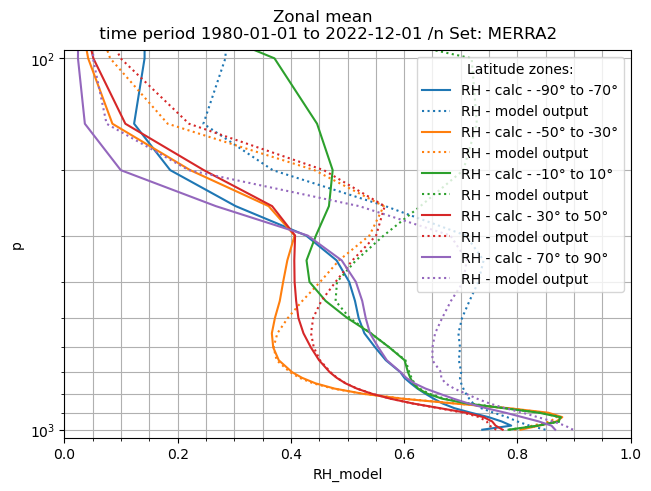

In [10]:
if TvsRHANALYSIS==True:
    #ZONES_Test =np.array([-90,-89]) # Zones between 1.,2. and 3.,4. and ...
    zones=ZONES_Helene
    
    fig, ax1 = plt.subplots(1,1, constrained_layout=True)
    
    with ProgressBar():
            raw = dask.compute(DS.ds.sel(time=slice(t2_start,t2_end)).mean(('time','lon')))[0]
    
    for i in range(0,int(0.5*len(zones))):
        l1 = zones[2*i]
        l2 = zones[2*i+1]
        
        with ProgressBar():
            Diff = dask.compute(raw.sel(lat=slice(l1,l2)).weighted(np.cos(np.deg2rad(DS.ds.lat))).mean(('lat')))[0]
        
        lh,=(Diff.RH_calc).plot.line(ax=ax1,y='p',yincrease=False, label = 'RH - calc - '+str(l1)+'° to '+str(l2)+'°',)
        Diff.RH_model.plot.line(ax=ax1,y='p',yincrease=False, label = 'RH - model output',color=lh.get_color(),linestyle='dotted',)
        #get_vertical_levels(Diff,1001,100).plot.scatter(ax=ax3,x='RH',y='T',yincrease=True) #, linestyle='-', marker=''
    
    TOP_LIM4PLOT=95
    ax1.set_ylim(top=TOP_LIM4PLOT)

    ax1.set_xlim((0,1))
    
    ax1.set_yscale('log')
    
    fig.suptitle('Zonal mean \n time period ' +t1_start+ ' to ' + t2_end+' /n Set: '+ SETNAME)
    ax1.legend(title = 'Latitude zones:')
    #plt.tight_layout()
    ax1.grid()
    ax1.grid(which = "minor")
    ax1.minorticks_on()
    
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'vertical_variable_profiles_'+DS.setname+'.png',dpi=400)
    
    plt.show()
    

[########################################] | 100% Completed | 276.81 s


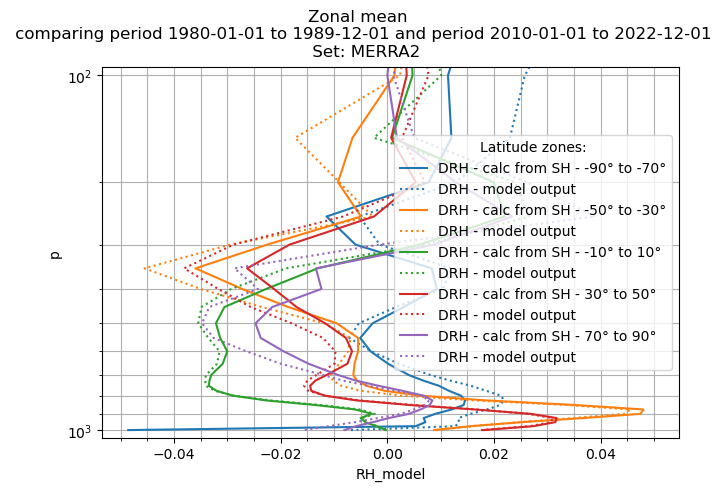

In [11]:
if TvsRHANALYSIS==True:
    fig, ax1= plt.subplots(1,1, constrained_layout=True)
    
    with ProgressBar():
            Raw = dask.compute(DS.ds.sel(time=slice(t2_start,t2_end)).mean(('time','lon')) - DS.ds.sel(time=slice(t1_start,t1_end)).mean(('time','lon')))[0]
           
    for i in range(0,int(0.5*len(zones))):
        l1 = zones[2*i]
        l2 = zones[2*i+1]
        
        with ProgressBar():
            Diff = dask.compute((Raw).sel(lat=slice(l1,l2)).weighted(np.cos(np.deg2rad(DS.ds.lat))).mean(('lat')))[0]
        
        lh,=Diff.RH_calc.plot.line(ax=ax1,y='p',yincrease=False, label = 'DRH - calc from SH - '+str(l1)+'° to '+str(l2)+'°')
        Diff.RH_model.plot.line(ax=ax1,y='p',yincrease=False, label = 'DRH - model output',color=lh.get_color(),linestyle='dotted',)
        
    TOP_LIM4PLOT=95
    ax1.set_ylim(top=TOP_LIM4PLOT)
    #ax1.set_xlim((-0.2,0.2))
    ax1.set_yscale('log')
    
    fig.suptitle('Zonal mean  \n comparing period ' +t1_start+ ' to ' + t1_end + ' and period '+ t2_start+ ' to ' + t2_end+' \n Set: '+ SETNAME)
    ax1.legend(title = 'Latitude zones:')
    #plt.tight_layout()
    ax1.grid()
    ax1.grid(which = "minor")
    ax1.minorticks_on()
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'vertical_variable_change_profiles_'+DS.setname+'.png',dpi=400)
    
    plt.show()
    